In [1]:
import os, sys
sys.path.insert(0, os.path.abspath(os.path.join("..", "..")))

# Simulated data

Fitted using KDE for trigger and background, so close to `open_cp.sepp`.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import datetime
import open_cp.sources.sepp as source_sepp
import open_cp.logger
open_cp.logger.log_to_true_stdout("sepp")
open_cp.logger.log_to_true_stdout("open_cp")
import sepp.sepp_grid
import sepp.sepp_full
import sepp.kernels

## The background sampler we'll use

In [3]:
grid = sepp.sepp_grid.ConcreteBoundedGrid(50, 50, 0, 0, 10, 10)
region = grid.region()

back_time_kernel = open_cp.sources.sepp.HomogeneousPoisson(1)
back_space_sampler = open_cp.sources.sepp.UniformRegionSampler(region)
background_sampler = open_cp.sources.sepp.InhomogeneousPoissonFactors(
    back_time_kernel, back_space_sampler)

trig_time_kernel = open_cp.sources.sepp.Exponential(exp_rate=10, total_rate=.5)
trig_space_sampler = open_cp.sources.sepp.GaussianSpaceSampler([0,0],[2,2],0)
trigger_sampler = open_cp.sources.sepp.InhomogeneousPoissonFactors(
    trig_time_kernel, trig_space_sampler)

simulate = open_cp.sources.sepp.SelfExcitingPointProcess(background_sampler, trigger_sampler)

In [4]:
details = simulate.sample_with_details(0, 365)

## Triggering

Seems exponential in time and Gaussian in space, as expected

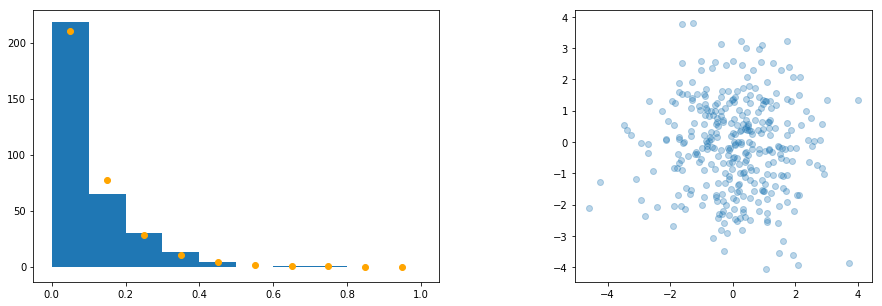

In [5]:
fig, axes = plt.subplots(ncols=2, figsize=(16,5))

axes[0].hist(details.trigger_deltas[0], bins=np.linspace(0,1,11))
x = np.linspace(0,1,11)
y = details.trigger_deltas.shape[1] * (np.exp(-10*x)[:-1] - np.exp(-10*x)[1:])
x += (x[1] - x[0])/2
axes[0].scatter(x[:-1], y, color="orange", zorder=10)
axes[1].scatter(*details.trigger_deltas[1:,], alpha=0.3)
axes[1].set_aspect(1)
None

In [6]:
print("Estimated omega =",
    1 / np.mean(details.trigger_deltas[0]) )
print("Estimated sigma^2 =",
    np.sum(details.trigger_deltas[1:]**2) / (2 * details.trigger_deltas.shape[1]) )

Estimated omega = 10.2143571393
Estimated sigma^2 = 2.00886504357


## Background

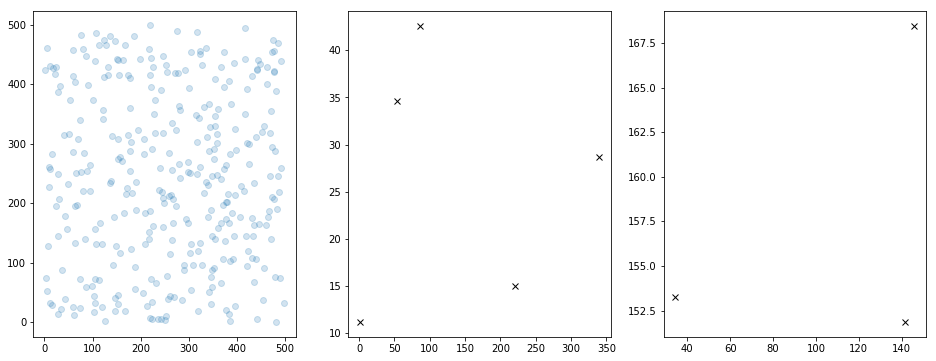

In [7]:
fig, axes = plt.subplots(ncols=3, figsize=(16,6))

xcs = details.backgrounds[1]
ycs = details.backgrounds[2]
axes[0].scatter(xcs, ycs, alpha=0.2)

m = (xcs < 50) & (ycs < 50)
times = details.backgrounds[0][m]
axes[1].scatter(times, xcs[m], marker="x", color="black", linewidth=1)

m = (xcs > 150) & (xcs < 200) & (ycs < 50)
times = details.backgrounds[0][m]
axes[2].scatter(times, xcs[m], marker="x", color="black", linewidth=1)

## Combined

In [8]:
points = details.points

m = (points[1] >= 0) & (points[1] < 500) & (points[2] >= 0) & (points[2] < 500)
points = points[:,m]
points.shape, details.points.shape

((3, 666), (3, 666))

In [9]:
time_unit = source_sepp.make_time_unit(datetime.timedelta(days=1))
timed_points = source_sepp.scale_to_real_time(points, datetime.datetime(2017,1,1),
    time_unit)
timed_points.time_range

(numpy.datetime64('2017-01-01T05:52:46.252'),
 numpy.datetime64('2017-12-31T20:49:34.169'))

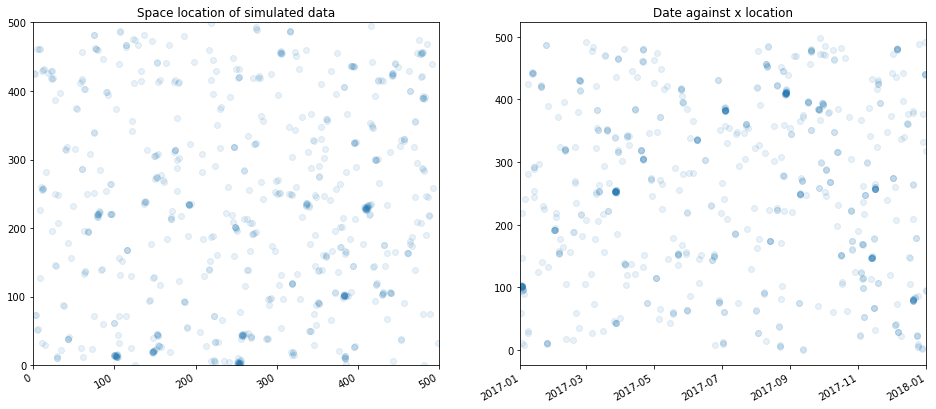

In [10]:
fig, ax = plt.subplots(ncols=2, figsize=(16,7))

ax[0].scatter(timed_points.xcoords, timed_points.ycoords, alpha=0.1)
ax[0].set_title("Space location of simulated data")
ax[0].set(xlim=[0,500], ylim=[0,500])

times = timed_points.times_datetime()
ax[1].scatter(times, timed_points.xcoords, alpha=0.1)
ax[1].set_xlim([datetime.datetime(2017,1,1), datetime.datetime(2018,1,1)])
ax[1].set_title("Date against x location")
fig.autofmt_xdate()
None

# Fit

In [11]:
trigger_ker_prov = sepp.kernels.FixedBandwidthKernelProvider(0.5, cutoff=7, scale=[0.02, 1, 1])
back_ker_prov = sepp.kernels.FixedBandwidthKernelProvider(50)
opt_fac = sepp.sepp_full.OptimiserFactory(back_ker_prov, trigger_ker_prov)
trainer = sepp.sepp_full.Trainer(opt_fac)
trainer.data = timed_points
T, data = trainer.make_data(datetime.datetime(2018,1,1))
model = trainer.initial_model(T, data)
model

Model(T=364.75502023148147, mu=1.8258830257561416, background=<open_cp.kernels.GaussianBase object at 0x000002158D06C630>, theta=0.5, trigger=<function Trainer.initial_model.<locals>.tk at 0x000002158CDBE8C8>

In [12]:
for _ in range(10):
    opt = trainer._optimiser(model, data)
    model = opt.iterate()
    print(model)

Model(T=364.75502023148147, mu=0.8662682455389212, background=<open_cp.kernels.GaussianBase object at 0x000002158A5AA5C0>, theta=0.5255620248837252, trigger=<open_cp.kernels.ReflectedKernel object at 0x000002158D18B390>
Model(T=364.75502023148147, mu=0.9129545734283431, background=<open_cp.kernels.GaussianBase object at 0x000002158D18BA20>, theta=0.49999284699507685, trigger=<open_cp.kernels.ReflectedKernel object at 0x000002158C7FA278>
Model(T=364.75502023148147, mu=0.9129415128780708, background=<open_cp.kernels.GaussianBase object at 0x000002158D18B390>, theta=0.5, trigger=<open_cp.kernels.ReflectedKernel object at 0x000002158C7FA6A0>
Model(T=364.75502023148147, mu=0.9129415128780708, background=<open_cp.kernels.GaussianBase object at 0x000002158D18BA20>, theta=0.5, trigger=<open_cp.kernels.ReflectedKernel object at 0x000002158C7FA6D8>
Model(T=364.75502023148147, mu=0.9129415128780708, background=<open_cp.kernels.GaussianBase object at 0x000002158D18B390>, theta=0.5, trigger=<open_c

In [13]:
xy_marginal = sepp.kernels.compute_space_marginal(model.trigger_kernel)
t_marginal = sepp.kernels.compute_t_marginal(model.trigger_kernel)

xb = np.linspace(-50, 550, 101)
yb = np.linspace(-50, 550, 101)
xcs, ycs = np.meshgrid(xb, yb)
z = model.background_kernel([xcs.flatten(), ycs.flatten()])
z_back = z.reshape(xcs.shape)

xt = np.linspace(-5, 5, 51)
yt = np.linspace(-5, 5, 51)
xcs, ycs = np.meshgrid(xt, yt)
z = xy_marginal([xcs.flatten(), ycs.flatten()])
z_trig = z.reshape(xcs.shape)

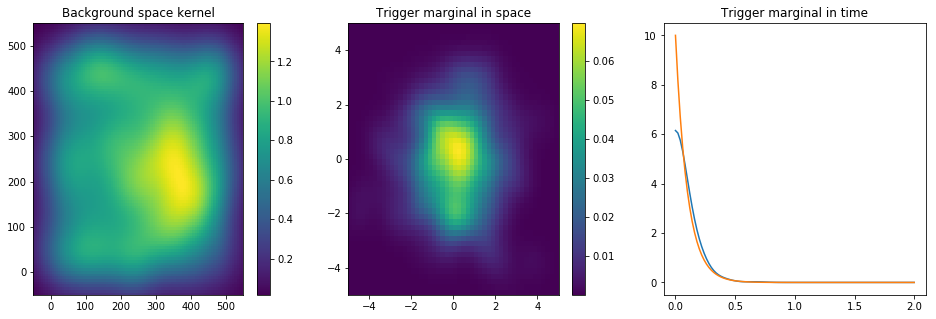

In [14]:
fig, axes = plt.subplots(ncols=3, figsize=(16,5))

ax = axes[0]
m = ax.pcolormesh(xb, yb, z_back * 500 * 500)
fig.colorbar(m, ax=ax)
ax.set_title("Background space kernel")

ax = axes[1]
m = ax.pcolormesh(xt, yt, z_trig)
fig.colorbar(m, ax=ax)
ax.set_title("Trigger marginal in space")

ax = axes[2]
t = np.linspace(0, 2, 101)
ax.plot(t, t_marginal(t))
ax.plot(t, 10 * np.exp(-10*t))
ax.set_title("Trigger marginal in time")
None

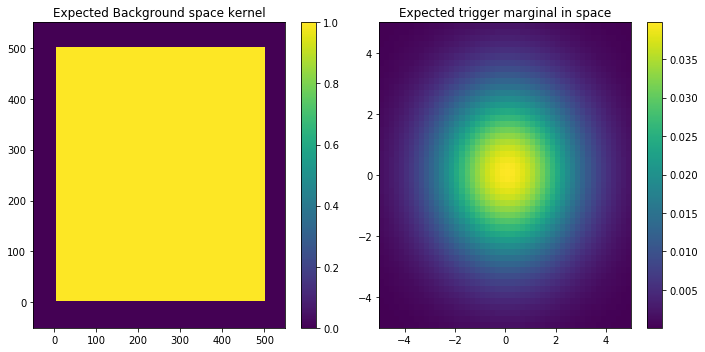

In [15]:
fig, axes = plt.subplots(ncols=2, figsize=(10,5))

ax = axes[0]
z = []
xcs, ycs = np.meshgrid(xb, yb)
for x, y in zip(xcs.flat, ycs.flat):
    inx = back_space_sampler.region.xmin <= x and x <= back_space_sampler.region.xmax
    iny = back_space_sampler.region.ymin <= y and y <= back_space_sampler.region.ymax
    if inx and iny:
        z.append(1)
    else:
        z.append(0)
z = np.asarray(z).reshape(xcs.shape) *500*500/ back_space_sampler.region.width / back_space_sampler.region.height
m = ax.pcolormesh(xb, yb, z)
fig.colorbar(m, ax=ax)
ax.set_title("Expected Background space kernel")

ax = axes[1]
z = []
xcs, ycs = np.meshgrid(xt, yt)
for x, y in zip(xcs.flat, ycs.flat):
    z.append( np.exp(-(x*x+y*y)/8) /  (8 * np.pi) )
z = np.asarray(z).reshape(xcs.shape)
m = ax.pcolormesh(xt, yt, z)
fig.colorbar(m, ax=ax)
ax.set_title("Expected trigger marginal in space")

fig.tight_layout()

# Stochastic EM algorithm

In [16]:
trigger_ker_prov = sepp.kernels.FixedBandwidthKernelProvider(0.5, cutoff=7, scale=[0.02, 1, 1])
back_ker_prov = sepp.kernels.FixedBandwidthKernelProvider(50)
opt_fac = sepp.sepp_full.OptimiserSEMFactory(back_ker_prov, trigger_ker_prov)
trainer = sepp.sepp_full.Trainer(opt_fac)
trainer.data = timed_points
T, data = trainer.make_data(datetime.datetime(2018,1,1))
model = trainer.initial_model(T, data)
model

Model(T=364.75502023148147, mu=1.8258830257561416, background=<open_cp.kernels.GaussianBase object at 0x000002158A63F518>, theta=0.5, trigger=<function Trainer.initial_model.<locals>.tk at 0x0000021590065840>

In [17]:
for _ in range(50):
    opt = trainer._optimiser(model, data)
    model = opt.iterate()
model

Model(T=364.75502023148147, mu=0.9156830789828098, background=<open_cp.kernels.GaussianBase object at 0x000002158CC41E48>, theta=0.4984984984984985, trigger=<open_cp.kernels.ReflectedKernel object at 0x000002158D191F60>

In [18]:
xy_marginal = sepp.kernels.compute_space_marginal(model.trigger_kernel)
t_marginal = sepp.kernels.compute_t_marginal(model.trigger_kernel)

xb = np.linspace(-50, 550, 101)
yb = np.linspace(-50, 550, 101)
xcs, ycs = np.meshgrid(xb, yb)
z = model.background_kernel([xcs.flatten(), ycs.flatten()])
z_back = z.reshape(xcs.shape)

xt = np.linspace(-5, 5, 51)
yt = np.linspace(-5, 5, 51)
xcs, ycs = np.meshgrid(xt, yt)
z = xy_marginal([xcs.flatten(), ycs.flatten()])
z_trig = z.reshape(xcs.shape)

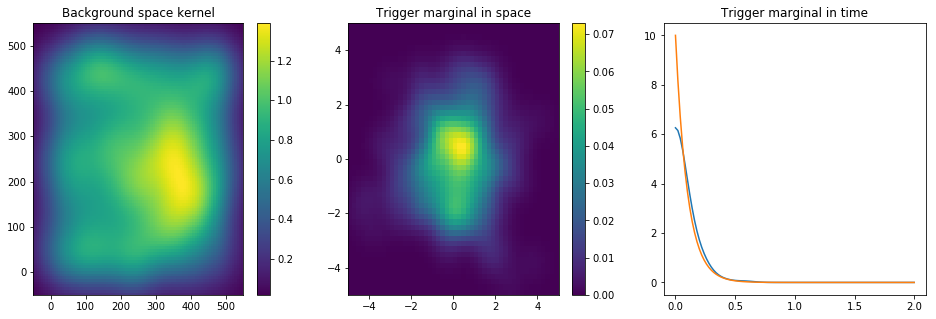

In [19]:
fig, axes = plt.subplots(ncols=3, figsize=(16,5))

ax = axes[0]
m = ax.pcolormesh(xb, yb, z_back * 500 * 500)
fig.colorbar(m, ax=ax)
ax.set_title("Background space kernel")

ax = axes[1]
m = ax.pcolormesh(xt, yt, z_trig)
fig.colorbar(m, ax=ax)
ax.set_title("Trigger marginal in space")

ax = axes[2]
t = np.linspace(0, 2, 101)
ax.plot(t, t_marginal(t))
ax.plot(t, 10 * np.exp(-10*t))
ax.set_title("Trigger marginal in time")
None

# With separate time and space triggers

In [20]:
tk_time_prov = sepp.kernels.FixedBandwidthKernelProvider(0.1, cutoff=1)
tk_space_prov = sepp.kernels.FixedBandwidthKernelProvider(1, cutoff=10)
back_ker_prov = sepp.kernels.FixedBandwidthKernelProvider(50)
opt_fac = sepp.sepp_full.Optimiser1Factory(back_ker_prov, tk_time_prov, tk_space_prov)
trainer = sepp.sepp_full.Trainer1(opt_fac)
trainer.data = timed_points
T, data = trainer.make_data(datetime.datetime(2018,1,1))
model = trainer.initial_model(T, data)
model

Model1(T=364.75502023148147, mu=1.8258830257561416, background=<open_cp.kernels.GaussianBase object at 0x000002158D191860>, theta=0.5, trigger=<function Trainer1.initial_model.<locals>.tk_time at 0x000002158CC7B730>,<function Trainer1.initial_model.<locals>.tk_space at 0x000002158C83AB70>

In [21]:
for _ in range(10):
    opt = trainer._optimiser(model, data)
    model = opt.iterate()
    print(model)

Model1(T=364.75502023148147, mu=0.6177148991001346, background=<open_cp.kernels.GaussianBase object at 0x000002158CE52B00>, theta=0.6616897739961611, trigger=<open_cp.kernels.Reflect1D object at 0x000002158CC6F2B0>,<open_cp.kernels.GaussianBase object at 0x000002158CC3A160>
Model1(T=364.75502023148147, mu=0.9129583785483026, background=<open_cp.kernels.GaussianBase object at 0x000002158CC6FF98>, theta=0.49999076300617623, trigger=<open_cp.kernels.Reflect1D object at 0x000002158CC3A940>,<open_cp.kernels.GaussianBase object at 0x000002158CC3AC50>
Model1(T=364.75502023148147, mu=0.9129862911495106, background=<open_cp.kernels.GaussianBase object at 0x000002158D10C940>, theta=0.4999754758268694, trigger=<open_cp.kernels.Reflect1D object at 0x000002158CC3ABE0>,<open_cp.kernels.GaussianBase object at 0x000002158CEA3898>
Model1(T=364.75502023148147, mu=0.9129950382510414, background=<open_cp.kernels.GaussianBase object at 0x0000021590092080>, theta=0.49997068521246124, trigger=<open_cp.kernel

In [22]:
xb = np.linspace(-50, 550, 101)
yb = np.linspace(-50, 550, 101)
xcs, ycs = np.meshgrid(xb, yb)
z = model.background_kernel([xcs.flatten(), ycs.flatten()])
z_back = z.reshape(xcs.shape)

In [23]:
xt = np.linspace(-5, 5, 51)
yt = np.linspace(-5, 5, 51)
xcs, ycs = np.meshgrid(xt, yt)
z = model.trigger_space_kernel([xcs.flatten(), ycs.flatten()])
z_trig = z.reshape(xcs.shape)

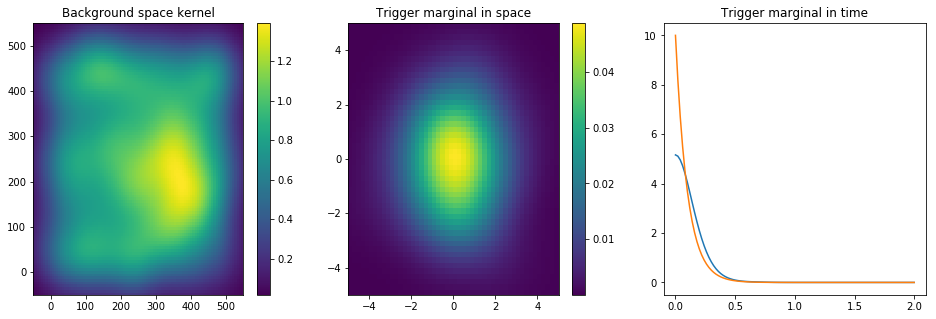

In [24]:
fig, axes = plt.subplots(ncols=3, figsize=(16,5))

ax = axes[0]
m = ax.pcolormesh(xb, yb, z_back*500*500)
fig.colorbar(m, ax=ax)
ax.set_title("Background space kernel")

ax = axes[1]
m = ax.pcolormesh(xt, yt, z_trig)
fig.colorbar(m, ax=ax)
ax.set_title("Trigger marginal in space")

ax = axes[2]
t = np.linspace(0, 2, 101)
ax.plot(t, model.trigger_time_kernel(t))
ax.plot(t, 10 * np.exp(-10*t))
ax.set_title("Trigger marginal in time")
None

## With Stochastic EM algorithm

In [25]:
tk_time_prov = sepp.kernels.FixedBandwidthKernelProvider(0.1, cutoff=1)
tk_space_prov = sepp.kernels.FixedBandwidthKernelProvider(1, cutoff=10)
back_ker_prov = sepp.kernels.FixedBandwidthKernelProvider(50)
opt_fac = sepp.sepp_full.Optimiser1SEMFactory(back_ker_prov, tk_time_prov, tk_space_prov)
trainer = sepp.sepp_full.Trainer1(opt_fac)
trainer.data = timed_points

model = trainer.train(datetime.datetime(2018,1,1), iterations=50)

In [26]:
xb = np.linspace(-50, 550, 101)
yb = np.linspace(-50, 550, 101)
xcs, ycs = np.meshgrid(xb, yb)
z = model.background_kernel([xcs.flatten(), ycs.flatten()])
z_back = z.reshape(xcs.shape)

xt = np.linspace(-5, 5, 51)
yt = np.linspace(-5, 5, 51)
xcs, ycs = np.meshgrid(xt, yt)
z = model.trigger_space_kernel([xcs.flatten(), ycs.flatten()])
z_trig = z.reshape(xcs.shape)

t = np.linspace(0, 2, 101)
tt = model.trigger_time_kernel(t)

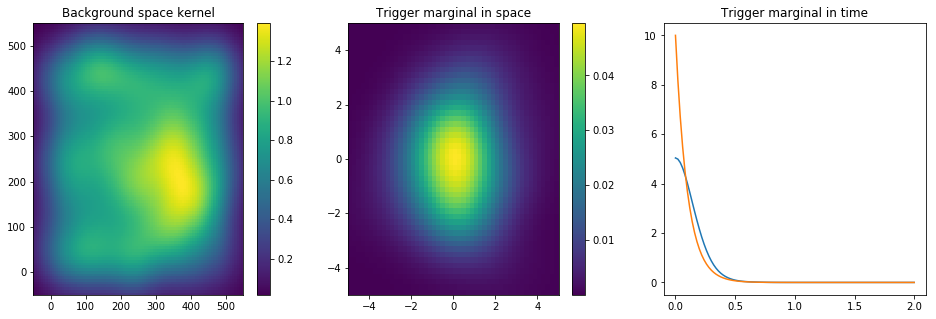

In [27]:
fig, axes = plt.subplots(ncols=3, figsize=(16,5))

ax = axes[0]
m = ax.pcolormesh(xb, yb, z_back*500*500)
fig.colorbar(m, ax=ax)
ax.set_title("Background space kernel")

ax = axes[1]
m = ax.pcolormesh(xt, yt, z_trig)
fig.colorbar(m, ax=ax)
ax.set_title("Trigger marginal in space")

ax = axes[2]
ax.plot(t, tt)
ax.plot(t, 10 * np.exp(-10*t))
ax.set_title("Trigger marginal in time")
None